In [2]:
import numpy as np
from numba import njit
from time import time
from osgeo import gdal
import pyarrow as pa
import benchit
benchit.setparams(environ='notebook')

Notebook environment set! Use "fontsize" & "figsize" args with plot method for better viewing experience.


## Sąlyga

Duota nuotrauka. Rasti, kiek kurių pikselių joje yra.

## MWE
### Input

    [[-3, -1,  2,  2,  2,  4, -1,  1,  0,  3],
    [ 1,  0, -1,  2,  3, -3, -1,  3,  1,  1],
    [-2,  0, -3, -2,  0,  1,  0,  0,  3,  0],
    [-3,  2,  0,  2,  1,  0, -3,  0, -3, -1],
    [-2,  0, -2,  5,  6, -1,  0, -4,  0,  0],
    [-2,  1,  0, -8,  0,  0, -3,  5,  1,  0],
    [ 0,  0,  0,  0, -4,  2,  1,  4, -1,  0],
    [-1,  0,  4, -6,  0,  1,  2,  0,  1, -2],
    [ 3,  6,  1,  1, -1,  1,  0,  0,  5,  0],
    [-2, -5, -4, -3,  8,  1,  2, -1,  4, -4]]

###  Expected output

    {-8: 1, -6: 1, -5: 1, -4: 4, -3: 8, -2: 7, -1: 10, 0: 29, 1: 15, 2: 9, 3: 5, 4: 4, 5: 3, 6: 2, 8: 1}

## Simulation

In [3]:
X = np.random.normal(scale=3, size=(10,10)).astype(int)
X

array([[-6,  0,  0, -1,  0,  6,  2, -5, -2, -4],
       [-1, -1, -5,  2,  4, -5,  5,  2, -1,  3],
       [ 1,  0, -2, -1,  0,  0,  0, -2, -5, -3],
       [ 2,  1,  4,  0, -1,  0, -2, -1, -2,  1],
       [ 1, -1,  0,  0,  7, -1,  1,  0,  0, -2],
       [-3,  0,  2,  1,  1,  0,  0, -3,  0,  4],
       [ 3,  0,  1,  1, -4,  2,  3,  0,  1, -1],
       [ 0, -4, -1,  2,  0,  1, -1,  1,  0,  3],
       [ 7,  0, -6, -3, -1, -3,  0,  6,  0,  0],
       [ 0,  5,  3, -7, -5, -5,  4,  0, -1,  2]])

or:

In [4]:
X = np.array([[ 4,  3, -1,  1,  0, -5,  3, -1, -2, -2],
       [-1,  0, -1,  1, -3,  3, -2, -4,  4,  0],
       [-1,  0,  2, -1,  0,  3,  4,  0,  1, -3],
       [ 0,  3,  5, -5, -2,  0, -7,  0,  5, -3],
       [ 5,  1,  1,  3,  1,  0,  1,  4,  2,  0],
       [-4, -2,  2,  2,  2,  0,  0,  2,  0,  4],
       [-1,  2,  0, -4,  2, -4,  1,  0, -3, -2],
       [ 0,  0, -2, -3, -3,  0,  0,  0,  0,  1],
       [ 0,  1, -1,  0, -1,  7,  1,  1,  1, -3],
       [-3,  5,  2,  0, -1,  2,  2, -3, -2,  4]])

## Solutions: no chunking used

In [5]:
def numpy_unique(arr):
    u, counts = np.unique(arr, return_counts=True) #viename masyve ID, kitame jų dažnumai
    return dict(zip(u, counts))
print(numpy_unique(X))

{-7: 1, -5: 2, -4: 4, -3: 9, -2: 8, -1: 10, 0: 25, 1: 13, 2: 11, 3: 6, 4: 6, 5: 4, 7: 1}


In [6]:
def numpy_unique_1D(arr):
    u, counts = np.unique(arr.ravel(), return_counts=True) #viename masyve ID, kitame jų dažnumai
    return dict(zip(u, counts))
print(numpy_unique_1D(X))

{-7: 1, -5: 2, -4: 4, -3: 9, -2: 8, -1: 10, 0: 25, 1: 13, 2: 11, 3: 6, 4: 6, 5: 4, 7: 1}


In [7]:
def numpy_bincount(arr):
    arr_flat = arr.ravel()
    m = np.min(arr_flat)
    bins = np.bincount(arr_flat - m)
    terms = np.arange(m, m + len(bins))
    idx = bins != 0
    terms, bins = terms[idx], bins[idx] #we are interested in nonzero counts only
    return dict(zip(terms, bins))
print(numpy_bincount(X))

{-7: 1, -5: 2, -4: 4, -3: 9, -2: 8, -1: 10, 0: 25, 1: 13, 2: 11, 3: 6, 4: 6, 5: 4, 7: 1}


In [8]:
def python_count(arr):
    m, M = np.min(arr), np.max(arr)
    counts = np.zeros(M - m + 1, dtype=int)
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            counts[arr[i, j] - m] += 1
    idx = np.arange(m, M + 1)
    nonzero_idx = counts != 0
    idx, counts = idx[nonzero_idx], counts[nonzero_idx]
    return dict(zip(idx, counts))
print(python_count(X))

{-7: 1, -5: 2, -4: 4, -3: 9, -2: 8, -1: 10, 0: 25, 1: 13, 2: 11, 3: 6, 4: 6, 5: 4, 7: 1}


In [9]:
@njit
def _numba_count(a, counts, count_from, m, n):
    for i in range(m):
        for j in range(n):
            counts[a[i,j] - count_from] += 1

def numba_count(arr): #just a refactor of Python count
    m, M = np.min(arr), np.max(arr)
    counts = np.zeros(M - m + 1, dtype=int)
    _numba_count(arr, counts, m, *arr.shape)
    idx = np.arange(m, M + 1)
    nonzero_idx = counts != 0
    idx, counts = idx[nonzero_idx], counts[nonzero_idx]
    return dict(zip(idx, counts))

print(numba_count(X))

{-7: 1, -5: 2, -4: 4, -3: 9, -2: 8, -1: 10, 0: 25, 1: 13, 2: 11, 3: 6, 4: 6, 5: 4, 7: 1}


In [10]:
@njit
def numba_arr_counts_2D(a, counts, m, n, minima):
    for i in range(m):
        for j in range(n):
            counts[a[i,j] - minima] += 1

def numba_count_chunks(arr, block_size=(1000, 1000)):
    m, M = arr.min(), arr.max()
    counts = np.zeros(M - m + 1, dtype=int)
    idx = np.arange(m, M + 1)
    for s1 in range(0, arr.shape[0], block_size[0]):
        for s2 in range(0, arr.shape[1], block_size[1]):
            chunk = arr[s1:s1+block_size[0], s2:s2+block_size[1]]
            numba_arr_counts_2D(chunk, counts, *chunk.shape, m) #make it parallel!   
    nonzero_idx = counts != 0
    idx, counts = idx[nonzero_idx], counts[nonzero_idx]
    return dict(zip(idx, counts))

print(numba_count(X))

{-7: 1, -5: 2, -4: 4, -3: 9, -2: 8, -1: 10, 0: 25, 1: 13, 2: 11, 3: 6, 4: 6, 5: 4, 7: 1}


In [11]:
def numpy_bincount_chunks(arr, block_size=(1000, 1000)):
    m, M = arr.min(), arr.max()
    idx = np.arange(m, M + 1)
    counts = np.zeros(M - m + 1, dtype=int)
    for s1 in range(0, arr.shape[0], block_size[0]):
        for s2 in range(0, arr.shape[1], block_size[1]):           
            chunk = arr[s1:s1+block_size[0], s2:s2+block_size[1]]
            bins = np.bincount(chunk.ravel() - m, minlength=M - m + 1)
            counts += bins
    nonzero_idx = counts != 0
    idx, counts = idx[nonzero_idx], counts[nonzero_idx]
    return dict(zip(idx, counts))
print(numpy_bincount_chunks(X))

{-7: 1, -5: 2, -4: 4, -3: 9, -2: 8, -1: 10, 0: 25, 1: 13, 2: 11, 3: 6, 4: 6, 5: 4, 7: 1}


### Testing performace of solutions

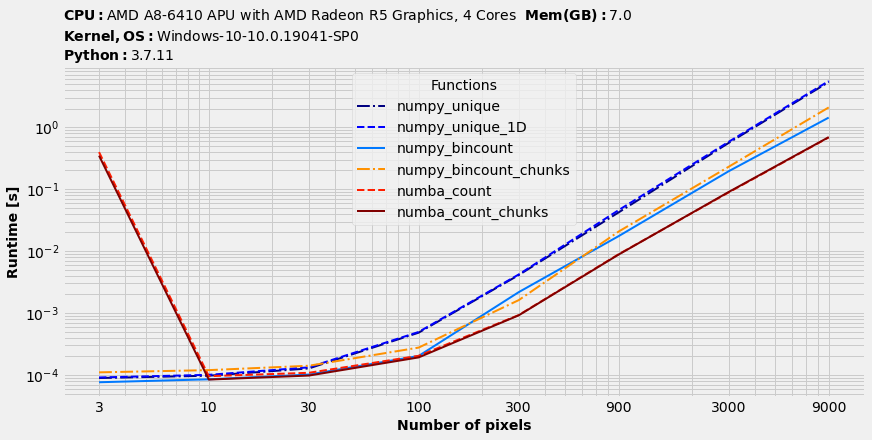

In [32]:
#TEST 1
%matplotlib inline
benchit.setparams(rep=1)

N=9000
arr = np.random.normal(scale=3, size=(N, N)).astype(int)
sizes = [3, 10, 30, 100, 300, 900, 3000, 9000]#, 30000]


fns = [numpy_unique, numpy_unique_1D, numpy_bincount, numpy_bincount_chunks, numba_count, numba_count_chunks] #python_count removed

in_ = {s: (arr[:s, :s], ) for s in sizes}
t = benchit.timings(fns, in_, multivar=True, input_name='Number of pixels')
t.plot(logx=True, figsize=(12, 6), fontsize=14)

arr done, time: 7.213


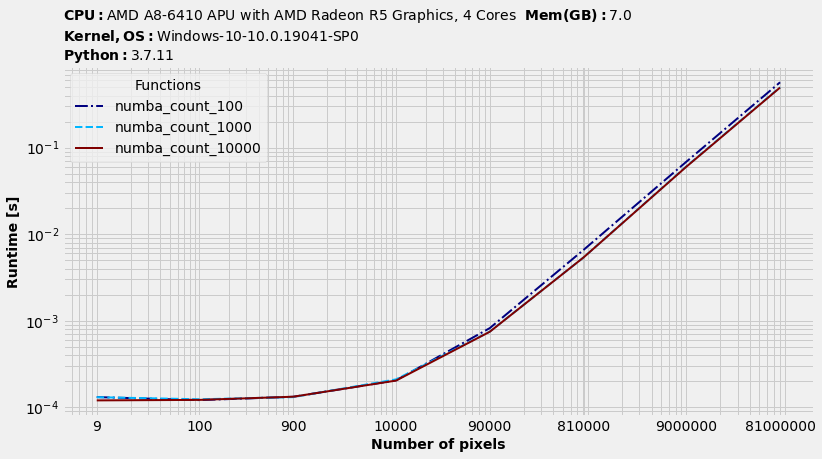

In [13]:
def numba_count_100(arr): return numba_count_chunks(arr, block_size = (100, 100))
def numba_count_1000(arr): return numba_count_chunks(arr, block_size = (1000, 1000))
def numba_count_10000(arr): return numba_count_chunks(arr, block_size = (3000, 3000))

N = 9000
t = time()
arr = np.random.normal(scale=3, size=(N, N)).astype(np.int8)
print('arr done, time:', round(time()-t,3))
sizes = [3, 10, 30, 100, 300, 900, 3000, 9000]
fns = [numba_count_100, numba_count_1000, numba_count_10000]

in_ = {s*s: (arr[:s, :s], ) for s in sizes}
t = benchit.timings(fns, in_, multivar=True, input_name='Number of pixels')
t.plot(logx=True, figsize=(12, 6), fontsize=14)

### Real data

In [4]:
#path = 'paseliai/clf_LIT_2021_ET100_18pas.tif'
path = 'paseliai/paseliai_2020_sklypo_ID.tif'

def read_raster_arr(path):
    '''returns array of blocks'''
    ds = gdal.OpenEx(path, gdal.GA_ReadOnly) #raster_dataset
    band = ds.GetRasterBand(1)
    return band.ReadAsArray()

def read_raster_gen(path):
    '''returns generator of blocks'''
    ds = gdal.OpenEx(path, gdal.GA_ReadOnly) #raster_dataset
    band = ds.GetRasterBand(1)
    w1, w2 = band.GetBlockSize()
    for i in range(0, ds.RasterXSize, w1):
        for j in range(0, ds.RasterYSize, w2):
            yield band.ReadAsArray(i, j, w1, w2)

### Process 1
1\. Convert .tiff into numpy array  
2\. Process it.

In [3]:
t = time()
arr = read_raster_arr(path)
print('arr done, time:', round(time()-t,3))

arr done, time: 48.503


In [75]:
@njit
def _numba_count_custom_arr(a, counts, m, n):
    for i in range(m):
        for j in range(n):
            temp = a[i,j]
            if temp != 4294967295:
                counts[temp] += 1

def numba_count_custom_arr(arr, chunk_size=1000, maxima=10000000):
    '''In cases minimum is zero and maximum = 10000000 is assigned manually'''
    m, n = arr.shape
    counts = np.zeros(maxima + 1, dtype=np.uint)
    for s1 in range(0, m, chunk_size):
        for s2 in range(0, n, chunk_size):
            chunk = arr[s1:s1+chunk_size, s2:s2+chunk_size]   
            _numba_count_custom_arr(chunk, counts, *chunk.shape) #make it parallel!   
    nonzero_idx = np.flatnonzero(counts).astype(np.uint)
    out = dict(zip(nonzero_idx, counts[nonzero_idx]))
    return {**{-1: arr.size - sum(out.values())}, **out} 

In [76]:
%%timeit -r 5 -n 3
numba_count_custom_arr(arr)

3.94 s ± 132 ms per loop (mean ± std. dev. of 5 runs, 3 loops each)


### Process 2
1\. Generate numpy arrays from .tiff 
2\. Process it.

In [86]:
t = time()
gen = read_raster_gen(path)
print('arr done, time:', round(time()-t,3))

arr done, time: 0.0


In [6]:
@njit
def _numba_count_custom_gen(a, counts, m, n):
    for i in range(m):
        for j in range(n):
            temp = a[i,j]
            if temp != 4294967295:
                counts[temp] += 1

def numba_count_custom_gen(gen, maxima=10000000):
    '''In cases minimum is zero and maximum = 10000000 is assigned manually'''
    counts = np.zeros(maxima + 1, dtype=np.uint)
    total_size = 0
    for block in gen:
        total_size += block.size
        _numba_count_custom_gen(block, counts, *block.shape) #make it parallel!   
    nonzero_idx = np.flatnonzero(counts).astype(np.uint)
    out = dict(zip(nonzero_idx, counts[nonzero_idx]))
    return {**{-1: total_size - sum(out.values())}, **out} 

In [11]:
@njit
def _numba_count_custom_gen1D(a, counts, m):
    for i in range(m):
        temp = a[i]
        if temp != 4294967295:
            counts[temp] += 1

def numba_count_custom_gen1D(gen, maxima=10000000):
    '''In cases minimum is zero and maximum = 10000000 is assigned manually'''
    counts = np.zeros(maxima + 1, dtype=np.uint)
    total_size = 0
    for block in gen:
        total_size += block.size
        _numba_count_custom_gen1D(block, counts, *block.shape) #make it parallel!   
    nonzero_idx = np.flatnonzero(counts).astype(np.uint)
    out = dict(zip(nonzero_idx, counts[nonzero_idx]))
    return {**{-1: total_size - sum(out.values())}, **out} 

In [103]:
%%timeit -r 3 -n 1
gen = read_raster_gen(path)
x = numba_count_custom_gen(gen, maxima=10000000)

56.5 s ± 28.3 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


### Process 3A, B
Write Arrow and Parquet

In [12]:
def pyarrow_write_arrow_BatchStream(arr, name):
    '''np.array -> .arrow file using pa.RecordBatchStreamWriter as writer'''
    arrays = [pa.array(col) for col in arr]
    names = [str(i) for i in range(len(arr))]
    batch = pa.RecordBatch.from_arrays(arrays, names=names)
    with pa.OSFile(name, 'wb') as sink:
        with pa.RecordBatchStreamWriter(sink, batch.schema) as writer:
            writer.write_batch(batch)

In [6]:
def pyarrow_read_arrow_BatchStream(name): #takes 0.05 seconds for 1e9 items
    with pa.memory_map(name, 'r') as source:
        batch = pa.ipc.RecordBatchStreamReader(source).read_all() #pa.Table
    return batch

In [108]:
arr = read_raster_arr(path)

(123, 8840486)

In [113]:
%%timeit -r 1 -n 1
pyarrow_write_arrow_BatchStream(arr.reshape(-1, 8840486), 'Lietuvos_paseliai.arrow')

1min ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [14]:
%%timeit -r 3 -n 1
table = pyarrow_read_arrow_BatchStream('Lietuvos_paseliai.arrow')   #BAD: .to_pandas().to_numpy()
gen = (table.column(str(i)).to_numpy() for i in range(table.num_columns))
numba_count_custom_gen1D(gen, maxima=10000000)

7.95 s ± 44.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
